# Курсовая работа
## Выполнил студент группы БФИ2202 Охримчук Павел Александрович


**Задание**




Написать программу, которая будет считывать данные из CSV файла, содержащего информацию о продажах товаров в магазине.
Данные в файле содержатся в следующем формате:
| Номер заказа | Дата заказа | Название товара | Категория товара | Количество продаж | Цена за единицу | Общая стоимость |

Также необходимо выполнить следующие пункты:

Рассчитать общую выручку магазина.
Найти товар, который был продан наибольшее количество раз.
Найти товар, который принес наибольшую выручку.
Составить отчет, содержащий информацию об общей выручке магазина, количестве проданных единиц каждого товар и доле каждого товара в общей выручке. Для решения задач необходимо использовать структуры данных, такие как массивы и хеш-таблицы, а также различные алгоритмы обработки данных, например, сортировку и поиск. Также необходимо учитывать возможные ошибки ввода-вывода и обрабатывать их в соответствии с требованиями.

***Код программы:***

Библиотеки для работы

In [58]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate


Класс для работы со стеком

In [59]:
class Stack:
    def __init__(self):
        self.items = []

    def is_empty(self):
        return self.items == []

    def push(self, item):
        self.items.append(item)

    def pop(self):
        if not self.is_empty():
            return self.items.pop()
        else:
            raise IndexError("Стек пуст")

Класс для работы с хеш-таблицами

In [60]:
class HashTable:
    class Entry:
        def __init__(self, key, value):
            self.key = key
            self.value = value
            self.next = None

    def __init__(self, initial_capacity=10):
        self.capacity = initial_capacity
        self.size = 0
        self.buckets = [None] * self.capacity

    def hash_function(self, key):
        return hash(key) % self.capacity

    def put(self, key, value):
        index = self.hash_function(key)
        if not self.buckets[index]:
            self.buckets[index] = self.Entry(key, value)
            self.size += 1
        else:
            current = self.buckets[index]
            while current:
                if current.key == key:
                    current.value = value
                    return
                if not current.next:
                    current.next = self.Entry(key, value)
                    self.size += 1
                    return
                current = current.next

    def get(self, key):
        index = self.hash_function(key)
        current = self.buckets[index]
        while current:
            if current.key == key:
                return current.value
            current = current.next
        return None

    def resize(self):
        new_capacity = self.capacity * 2
        new_buckets = [None] * new_capacity
        for bucket in self.buckets:
            current = bucket
            while current:
                index = self.hash_function(current.key) % new_capacity
                if not new_buckets[index]:
                    new_buckets[index] = self.Entry(current.key, current.value)
                else:
                    temp = new_buckets[index]
                    while temp.next:
                        temp = temp.next
                    temp.next = self.Entry(current.key, current.value)
                current = current.next
        self.capacity = new_capacity
        self.buckets = new_buckets





Функция для сортировки слиянием

In [61]:
def merge_sort(arr):
    if len(arr) <= 1:
        return arr

    mid = len(arr) // 2
    left_half = arr[:mid]
    right_half = arr[mid:]

    merge_sort(left_half)
    merge_sort(right_half)

    left_stack = Stack()
    right_stack = Stack()

    for item in reversed(left_half):
        left_stack.push(item)
    for item in reversed(right_half):
        right_stack.push(item)

    sorted_arr = []
    while not left_stack.is_empty() and not right_stack.is_empty():
        if left_stack.items[-1] < right_stack.items[-1]:
            sorted_arr.append(left_stack.pop())
        else:
            sorted_arr.append(right_stack.pop())

    while not left_stack.is_empty():
        sorted_arr.append(left_stack.pop())

    while not right_stack.is_empty():
        sorted_arr.append(right_stack.pop())

    for i in range(len(sorted_arr)):
        arr[i] = sorted_arr[i]

    return arr

Класс для обработки данных о продажах

In [62]:
class SalesDataProcessor:
    def __init__(self):
        self.total_revenue = 0
        self.max_sold_quantity = 0
        self.top_selling_item = ""
        self.revenue_array = []
        self.sales_quantity = HashTable()
        self.sales_revenue = HashTable()

    def process_row(self, row):
        order_number, order_date, item_name, item_category, quantity_sold, unit_price, total_cost = row
        quantity_sold = int(quantity_sold)
        total_cost = int(total_cost)

        self.total_revenue += total_cost

        if quantity_sold > self.max_sold_quantity:
            self.max_sold_quantity = quantity_sold
            self.top_selling_item = item_name

        self.revenue_array.append(total_cost)

        existing_quantity = self.sales_quantity.get(item_name)
        if existing_quantity is None:
            self.sales_quantity.put(item_name, quantity_sold)
            self.sales_revenue.put(item_name, total_cost)
        else:
            self.sales_quantity.put(item_name, existing_quantity + quantity_sold)
            self.sales_revenue.put(item_name, self.sales_revenue.get(item_name) + total_cost)

    def calculate_statistics(self):
        sorted_revenue = merge_sort(self.revenue_array)
        max_revenue_item = None
        for item_name in self.sales_revenue.buckets:
            if item_name is not None:
                current = item_name
                while current:
                    if current.value == sorted_revenue[-1]:
                        max_revenue_item = current.key
                    current = current.next
        return self.total_revenue, self.top_selling_item, max_revenue_item

    def print_statistics(self, file_reader):
        for row in file_reader:
            item_name = row[2]
            quantity_sold = self.sales_quantity.get(item_name)
            item_revenue = self.sales_revenue.get(item_name)
            revenue_share = round(item_revenue / self.total_revenue * 100, 2)
            print(f'{item_name}: продано {quantity_sold} единиц, доля в общей выручке составляет {revenue_share}%')

Функция для построения графиков

In [63]:
def plot_results(dataset, total_revenue, top_selling_item, max_revenue_item):
    dataset['Доля от общей выручки в %'] = (dataset['Общая стоимость'] / total_revenue) * 100
    dataset['Доля от общей выручки в %'] = dataset['Доля от общей выручки в %'].round(2)
    dataset.index = dataset['Название товара']

    plt.figure(figsize=(12, 6))
    result = dataset[['Доля от общей выручки в %']]

    result.plot(kind='bar', color='red')
    plt.xlabel('Название товара', fontsize=12)
    plt.ylabel('Доля от общей выручки в %', fontsize=12)
    plt.title('Доля каждого товара в общей выручке', fontsize=14)
    plt.xticks(rotation=90, fontsize=10)

    plt.show()

Функция для вывода таблицы в консоль

In [64]:
def print_table_to_console(dataset):
    table_str = tabulate(dataset, headers='keys', tablefmt='psql', showindex=False)
    print("\nТаблица данных:")
    print(table_str)

Чтение и обработка данных о продажах

In [65]:
processor = SalesDataProcessor()


try:
    dataset = pd.read_csv('data.csv', sep=';')
    with open("data.csv", encoding='utf-8') as file:
        file_reader = csv.reader(file, delimiter=";")
        next(file_reader)
        for row in file_reader:
            processor.process_row(row)

    total_revenue, top_selling_item, max_revenue_item = processor.calculate_statistics()

    print()
    print(f'Суммарная выручка магазина: {total_revenue} рублей')
    print(f'Товар с наибольшим количеством продаж: {top_selling_item}')
    print(f'Товар с максимальной выручкой: {max_revenue_item}')
    print()

    # Вывод статистики
    with open("data.csv", encoding='utf-8') as file:
        file_reader = csv.reader(file, delimiter=";")
        next(file_reader)  # Пропуск заголовка
        processor.print_statistics(file_reader)
    print()

except FileNotFoundError:
    print('Файл не найден')


Суммарная выручка магазина: 151225 рублей
Товар с наибольшим количеством продаж: Яблоки
Товар с максимальной выручкой: Мясо говяжье

Яблоки: продано 500 единиц, доля в общей выручке составляет 16.53%
Мандарины: продано 300 единиц, доля в общей выручке составляет 7.94%
Бананы: продано 200 единиц, доля в общей выручке составляет 3.97%
Молоко: продано 150 единиц, доля в общей выручке составляет 5.95%
Хлеб: продано 100 единиц, доля в общей выручке составляет 1.32%
Масло оливковое: продано 50 единиц, доля в общей выручке составляет 3.31%
Сыр: продано 100 единиц, доля в общей выручке составляет 5.29%
Курица: продано 75 единиц, доля в общей выручке составляет 7.44%
Рис: продано 25 единиц, доля в общей выручке составляет 0.83%
Макароны: продано 500 единиц, доля в общей выручке составляет 9.92%
Мясо говяжье: продано 200 единиц, доля в общей выручке составляет 26.45%
Картофель: продано 100 единиц, доля в общей выручке составляет 1.32%
Морковь: продано 150 единиц, доля в общей выручке составляет

Вывод таблицы в консоль

In [66]:

print_table_to_console(dataset)


Таблица данных:
+----------------+---------------+-------------------+-----------------------+---------------------+-------------------+-------------------+
|   Номер заказа | Дата заказа   | Название товара   | Категория товара      |   Количество продаж |   Цена за единицу |   Общая стоимость |
|----------------+---------------+-------------------+-----------------------+---------------------+-------------------+-------------------|
|              1 | 01.02.2022    | Яблоки            | Фрукты                |                 500 |                50 |             25000 |
|              2 | 02.04.2022    | Мандарины         | Фрукты                |                 300 |                40 |             12000 |
|              3 | 03.01.2022    | Бананы            | Фрукты                |                 200 |                30 |              6000 |
|              4 | 04.02.2022    | Молоко            | Молочные продукты     |                 150 |                60 |              900

Построение графиков для анализа данных

<Figure size 1200x600 with 0 Axes>

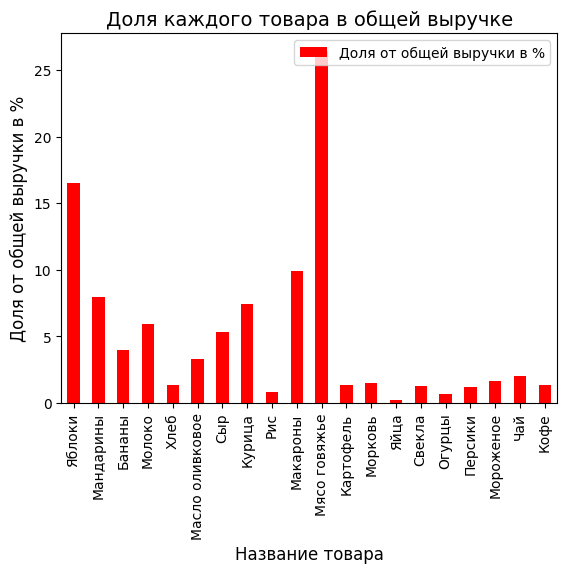

In [67]:
plot_results(dataset, total_revenue, top_selling_item, max_revenue_item)